In [32]:
from SupertypeTools import CGCalcMat, heatmap, SSE, hierarchical_cluster
import pandas as pd
import matplotlib.pyplot as plt
# contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171] #MHCpan
# contactA = [5,7,9,24,25,34,45,59,63,66,67,70,74,77,80,81,84,97,99,113,114,116,123,133,143,146,147,152,155,156,159,160,163,167,171]
# contactB = [5,7,8,9,24,45,59,62,63,65,66,67,70,73,74,76,77,80,81,84,95,97,99,114,116,123,143,146,147,152,155,156,159,160,163,167,171]

# weight = {3:[7,9,24,45,62,63,66,67,70,74,77,80,81,84,95,97,99,116,118,143,147,159]}

#Hanneke W.M. van Deutekom and Can Kesmir 2015
contact = [7,9,24,45,59,63,66,67,69,70,74,76,77,80,95,97,99,114,116,152,156,158,163,167,171]
weight = {9.9:[63],7.6:[67],5.8:[116],5.4:[9],4.7:[97],4.6:[152],3.8:[167],3.7:[156],3.6:[74],3.2:[70],3:[80],2.9:[171],2.8:[45],2.7:[66],2.7:[77],2.4:[76],2.3:[114],2.1:[99],1.5:[163],1.5:[95],1.4:[59],1.4:[158],1.2:[69],1.2:[24],1:[7]}

## Tuning number of clusters

In [33]:
def Tuning_N(StructureDistMat, BADistMat, Nmin, Nmax):
    StructSSE = []
    BASSE = []

    RAND_SSE = []

    # dist_list = []

    for i in range(Nmin, Nmax+1):
        cluster, _ = hierarchical_cluster(StructureDistMat, N=i, L='complete', threshold=None)
        #complete average single
        groups = [i[1].index.tolist() for i in cluster.groupby(cluster)]
        # print(groups)
        
        Struct_err = SSE(StructureDistMat, groups)
        StructSSE.append(Struct_err)

        if BADistMat is not None:
            BA_err = SSE(BADistMat, groups)
            BASSE.append(BA_err)

        else:
            BA_err = 'NA'

        print(f"N={i}  SE: {Struct_err} / BE: {BA_err}")

        # dist_list.append(dist)

    return StructSSE, BASSE

def elbow_plot(Struct_Mat, BA_Mat, Additional_Bar_group:list=None, Nmin=1, Nmax=12):
    
    SSE_struct, SSE_BA = Tuning_N(Struct_Mat, BA_Mat, Nmin, Nmax)
    xx = range(Nmin, Nmax+1)

    lines = []
    labels = []

    fig, ax1 = plt.subplots(figsize=(6,10))
    ax2 = ax1.twinx()

    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="NetMHCpan SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure SSE")
    lines.append(line1)
    labels.append("NetMHCpan SSE")
    lines.append(line2)
    labels.append("Structure SSE")

    ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,Nmax+1,2))
    ax1.tick_params(axis='x', labelsize=16)
    
    ax1.set_ylabel('Binding peptide SSE', color='tab:blue', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)

    ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    if Additional_Bar_group:
        for group in Additional_Bar_group:
            lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
            labels.append(f"{group[2]} (n={group[0]})")

    # ax1.legend()
    # ax2.legend()
    ax1.legend(lines, labels, prop={"size":16})
    ax1.grid(linestyle='--')

    # fig.legend()
    plt.show()

    return

BA_Mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)

### HLA-A

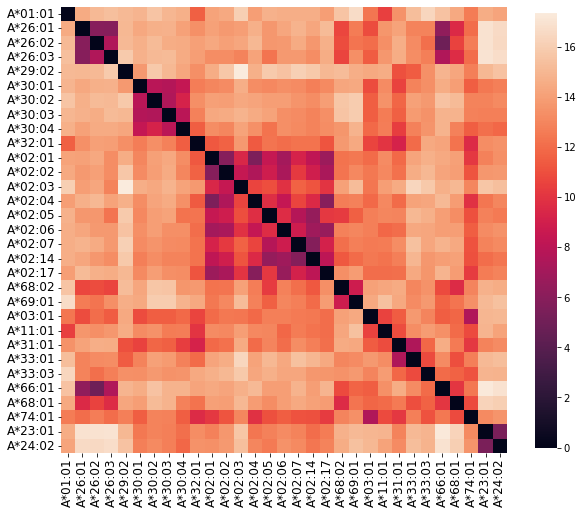

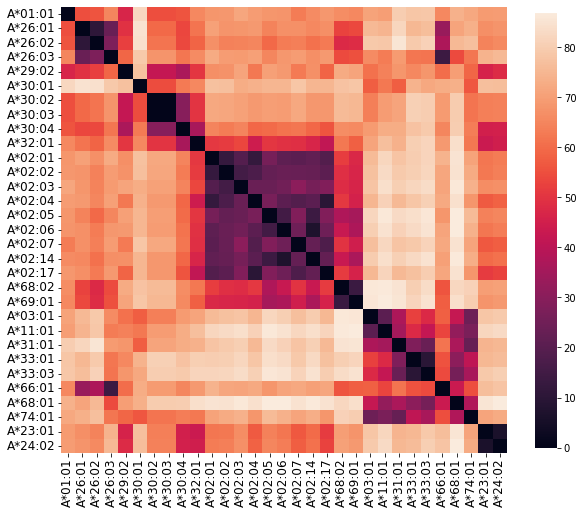

In [34]:
A_order = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]
A_label = ['A*01:01', 'A*26:01', 'A*26:02', 'A*26:03', 'A*29:02', 'A*30:01', 'A*30:02', 'A*30:03', 'A*30:04', 'A*32:01', 'A*02:01', 'A*02:02', 'A*02:03', 'A*02:04', 'A*02:05', 'A*02:06', 'A*02:07', 'A*02:14', 'A*02:17', 'A*68:02', 'A*69:01', 'A*03:01', 'A*11:01', 'A*31:01', 'A*33:01', 'A*33:03', 'A*66:01', 'A*68:01', 'A*74:01', 'A*23:01', 'A*24:02']

AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight, sigma=0.1, w=4)
# AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight)
heatmap(AMat, order=A_order, label=A_label, line=False, shrink=0.8, labelsize=12)
heatmap(BA_Mat, order=A_order, label=A_label, line=False, shrink=0.8, labelsize=12)

In [35]:
# Sidney
A_Sidney = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]

# Doytchinova
A_Doytchinova = [
    ['A01_01','A29_02','A30_01','A30_02','A30_03','A30_04','A32_01','A03_01','A11_01','A31_01','A33_01','A33_03','A66_01','A68_01','A74_01'],
    ['A26_01','A26_02','A26_03','A02_01','A02_02','A02_03','A02_04','A02_05','A02_06','A02_07','A02_14','A02_17','A68_02','A69_01'],
    ['A23_01','A24_02']
]
# elbow_plot(Mat, BA_Mat)
ASidney_SSE = SSE(BA_Mat, A_Sidney)
ADoytchinova_SSE = SSE(BA_Mat, A_Doytchinova)
ASSE_struct, ASSE_BA = Tuning_N(AMat, BA_Mat, 1, 12)

# elbow_plot(AMat, BA_Mat, [(len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")])
print(f"Sidney SSE:{ASidney_SSE}\nDoytchinova SSE:{ADoytchinova_SSE}")
# elbow_plot(Mat, BA_Mat)

N=1  SE: 193.01032149923924 / BE: 926.3061583577713
N=2  SE: 172.1420887137783 / BE: 785.0067424242425
N=3  SE: 156.43107116819738 / BE: 715.2578787878788
N=4  SE: 137.1199630619363 / BE: 583.8863636363637
N=5  SE: 127.28765305616811 / BE: 555.7053787878789
N=6  SE: 118.6511160515522 / BE: 494.41181818181815
N=7  SE: 107.7305624676632 / BE: 432.53151515151507
N=8  SE: 100.12188796849138 / BE: 395.620303030303
N=9  SE: 93.6964909621916 / BE: 354.19030303030297
N=10  SE: 85.7347806927506 / BE: 340.5584848484848
N=11  SE: 79.49184778072257 / BE: 300.7478787878788
N=12  SE: 73.47715488177714 / BE: 280.8433333333333
Sidney SSE:524.2076652892563
Doytchinova SSE:676.5420346320349


### HLA-B

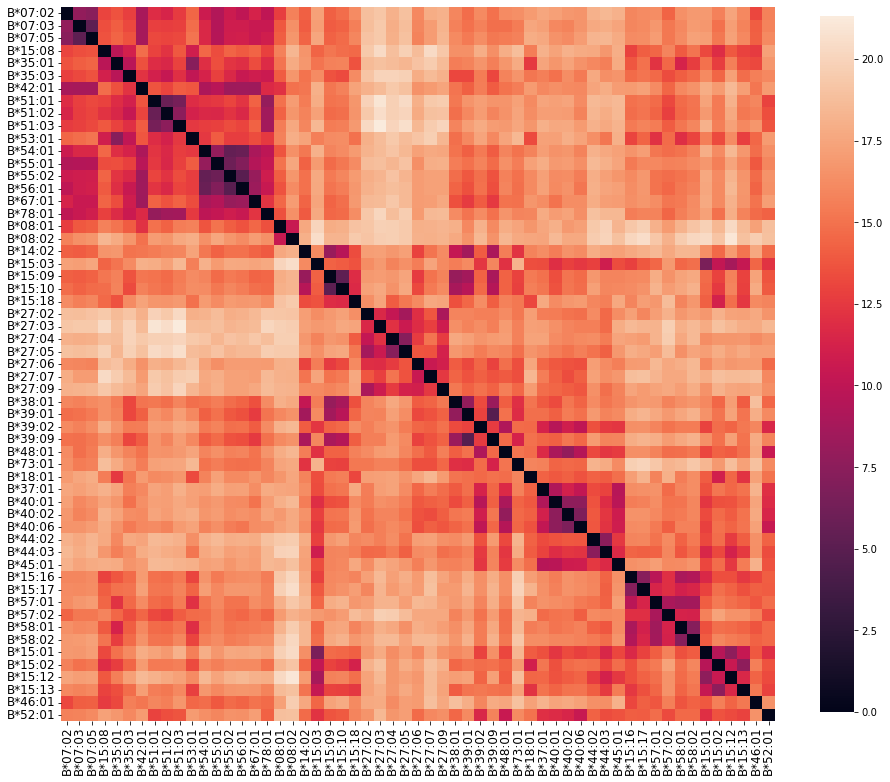

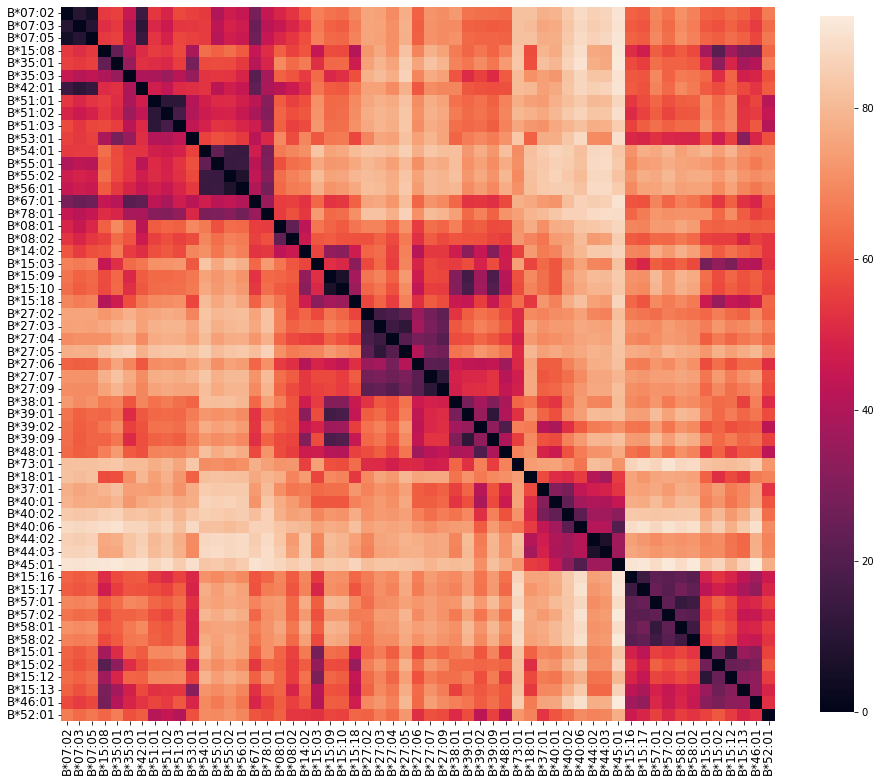

In [36]:
B_order = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
B_label = ['B*07:02','B*07:03','B*07:05','B*15:08','B*35:01','B*35:03','B*42:01','B*51:01','B*51:02','B*51:03','B*53:01','B*54:01','B*55:01','B*55:02','B*56:01','B*67:01','B*78:01','B*08:01','B*08:02','B*14:02','B*15:03','B*15:09','B*15:10','B*15:18','B*27:02','B*27:03','B*27:04','B*27:05','B*27:06','B*27:07','B*27:09','B*38:01','B*39:01','B*39:02','B*39:09','B*48:01','B*73:01','B*18:01','B*37:01','B*40:01','B*40:02','B*40:06','B*44:02','B*44:03','B*45:01','B*15:16','B*15:17','B*57:01','B*57:02','B*58:01','B*58:02','B*15:01','B*15:02','B*15:12','B*15:13','B*46:01','B*52:01']

BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight, sigma=0.1,w=4)
# BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight)
heatmap(BMat, order=B_order, size=(16,16), label=B_label, line=False, shrink=0.8, labelsize=12)
heatmap(BA_Mat, order=B_order, size=(16,16), label=B_label, line=False, shrink=0.8, labelsize=12)

In [37]:
# Sidney
B_Sidney = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
# Doytchinova
B_Doytchinova = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01','B08_01','B14_02','B15_09','B15_10','B15_18','B39_01','B39_09','B73_01','B18_01','B15_02'],
    ['B51_01','B51_02','B51_03','B53_01','B08_02','B27_02','B38_01','B44_02','B44_03','B57_01','B57_02','B58_01','B58_02','B52_01'],
    ['B15_03','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B39_02','B48_01','B37_01','B40_01','B40_02','B40_06','B45_01','B15_16','B15_17','B15_01','B15_12','B15_13','B46_01']
]

BSidney_SSE = SSE(BA_Mat, B_Sidney)
BDoytchinova_SSE = SSE(BA_Mat, B_Doytchinova)
BSSE_struct, BSSE_BA = Tuning_N(BMat, BA_Mat, 1, 12)
# elbow_plot(BMat, BA_Mat, [(len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")])
print(f"Sidney SSE:{BSidney_SSE}\nDoytchinova SSE:{BDoytchinova_SSE}")

N=1  SE: 431.5929735008743 / BE: 1771.7253588516746
N=2  SE: 383.5827516400151 / BE: 1525.881310624859
N=3  SE: 369.2721295147832 / BE: 1469.4234726295213
N=4  SE: 341.4079148348224 / BE: 1324.0944391392923
N=5  SE: 324.31428864692515 / BE: 1208.9525216450218
N=6  SE: 301.46940205233557 / BE: 1099.606417748918
N=7  SE: 276.4885163082621 / BE: 941.9078915202444
N=8  SE: 267.9466688398003 / BE: 912.1072421695951
N=9  SE: 250.30556669420784 / BE: 838.3778823953824
N=10  SE: 241.6198519404228 / BE: 816.8935966810967
N=11  SE: 232.86987221605224 / BE: 783.7956746031746
N=12  SE: 223.31912937930937 / BE: 743.1696139971141
Sidney SSE:1030.7893345216874
Doytchinova SSE:1541.298989271598


### HLA-C

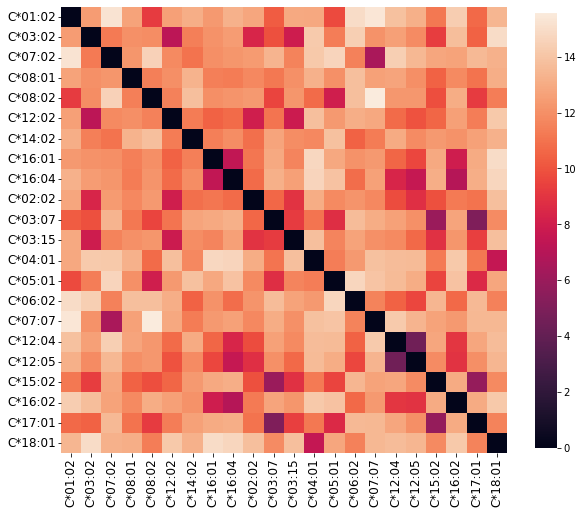

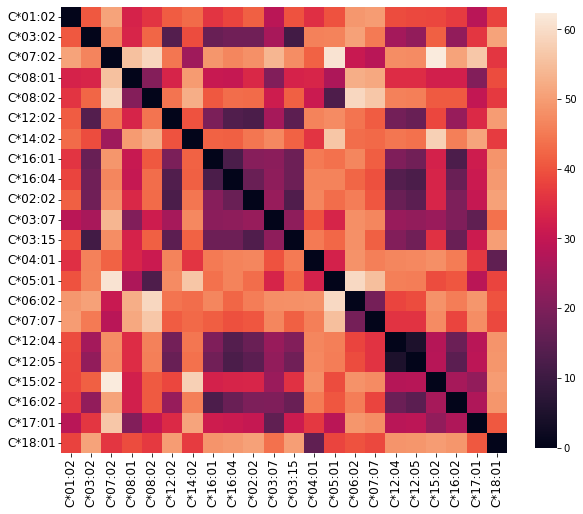

In [38]:
C_order = [
    ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
C_label = ['C*01:02','C*03:02','C*07:02','C*08:01','C*08:02','C*12:02','C*14:02','C*16:01','C*16:04','C*02:02','C*03:07','C*03:15','C*04:01','C*05:01','C*06:02','C*07:07','C*12:04','C*12:05','C*15:02','C*16:02','C*17:01','C*18:01']

CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight, sigma=0.1, w=4)
# CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight)
heatmap(CMat, order=C_order, label=C_label, line=False, shrink=0.8, labelsize=12)

BA_Mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)
heatmap(BA_Mat, order=C_order, label=C_label, line=False, shrink=0.8, labelsize=12)

In [39]:
# Doytchinova
C_Doytchinova = [
    ['C01_02','C03_02','C07_02','C08_01','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
CDoytchinova_SSE = SSE(BA_Mat, C_Doytchinova)
CSSE_struct, CSSE_BA = Tuning_N(CMat, BA_Mat, 1, 12)
# elbow_plot(CMat, BA_Mat, [(len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova")])
print(f"Doytchinova SSE:{CDoytchinova_SSE}")

N=1  SE: 124.11088670928744 / BE: 381.9780991735537
N=2  SE: 109.23921883775165 / BE: 337.9586776859504
N=3  SE: 96.734623313313 / BE: 284.0957300275482
N=4  SE: 86.90860927801211 / BE: 254.47906336088158
N=5  SE: 78.06640746502788 / BE: 219.68674242424242
N=6  SE: 71.2746488972122 / BE: 201.8609848484849
N=7  SE: 62.339592852612995 / BE: 165.0871212121212
N=8  SE: 56.00823982963756 / BE: 147.30833333333334
N=9  SE: 49.27448226077156 / BE: 134.1651515151515
N=10  SE: 43.35615593256776 / BE: 109.23030303030303
N=11  SE: 38.37065948562866 / BE: 86.06818181818183
N=12  SE: 33.958131448726874 / BE: 78.57424242424241
Doytchinova SSE:335.9124125874126


In [40]:
# random clustering as baseline
import random
import numpy as np

A_ref_alleles = ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01',
'A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01',
'A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01',
'A23_01', 'A24_02']
B_ref_alleles = ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01',
'B08_01','B08_02',
'B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01',
'B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01',
'B15_16','B15_17','B57_01','B57_02','B58_01','B58_02',
'B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
C_ref_alleles = ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04',
'C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
ALL_REF = [A_ref_alleles, B_ref_alleles, C_ref_alleles]

RAND_BA_SSE = []
for ref_alleles in ALL_REF:
    mean_sse = []
    std_sse = []
    for i in range(1, 13):
        n_cluster_sse = []
        for _ in range(5):
            random.shuffle(ref_alleles)
            rand_split = np.array_split(ref_alleles, i)
            # print(rand_split)
            n_cluster_sse.append(SSE(BA_Mat, rand_split))
        mean_sse.append(np.mean(n_cluster_sse))
        std_sse.append(np.std(n_cluster_sse))

    RAND_BA_SSE.append((mean_sse, std_sse))


In [41]:
# RAND_BA_SSE

### combine all three subplots

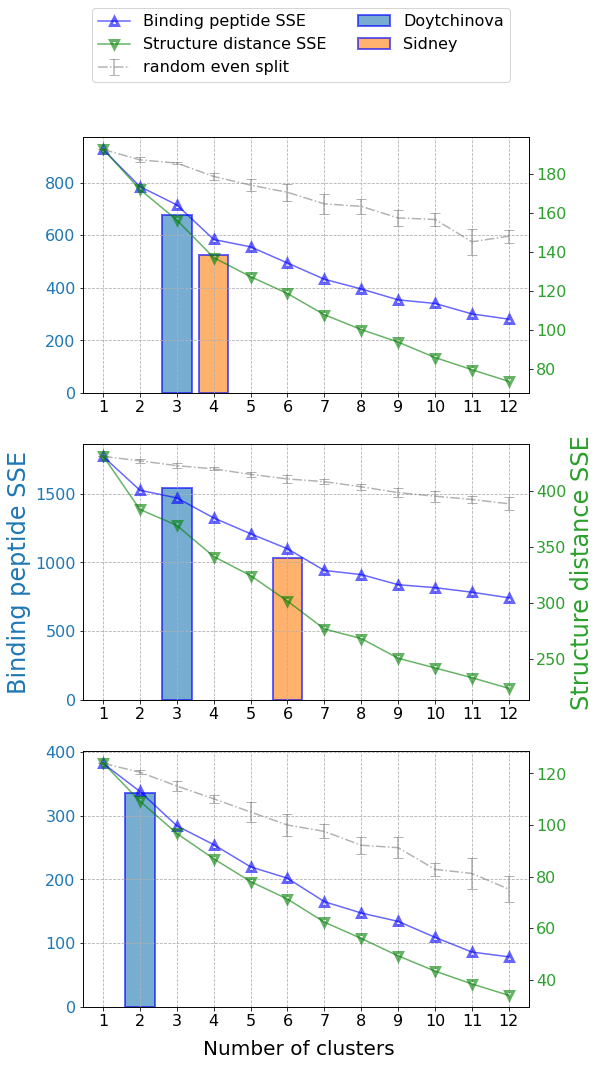

In [46]:
SSE_BA_list = [ASSE_BA, BSSE_BA, CSSE_BA]
SSE_struct_list = [ASSE_struct, BSSE_struct, CSSE_struct]
SSE_other = [((len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")), ((len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")), ((len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova"),)]

xx = range(1, 13)

fig, axes = plt.subplots(3, 1, figsize=(8,16))
i=1
for ax1, SSE_BA, SSE_struct, SSE_random, Additional_Bar_group in zip(axes, SSE_BA_list, SSE_struct_list, RAND_BA_SSE, SSE_other):

    # lines = []
    # labels = []
    ax2 = ax1.twinx()

    # line plots
    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="Binding peptide SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure distance SSE")
    # lines.append(line1)
    # labels.append("Binding peptide SSE")
    # lines.append(line2)
    # labels.append("Structure distance SSE")

    # random splits
    randoms = ax1.errorbar(xx, SSE_random[0], yerr=SSE_random[1], alpha=0.6, ls='-.', capsize=5, color='gray', label="random even split")
    # lines.append(randoms)
    # labels.append("random even split SSE")

    # ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,13,1))
    ax1.tick_params(axis='x', labelsize=16)

    if i == 2:
        lines = []
        labels = []
        lines.append(line1)
        labels.append("Binding peptide SSE")
        lines.append(line2)
        labels.append("Structure distance SSE")
        lines.append(randoms)
        labels.append("random even split")

        ax1.set_ylabel('Binding peptide SSE', color='tab:blue', fontsize=24)
        ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
    

    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    # bar plots
    for group in Additional_Bar_group:
        # print(group)
        # lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
        # labels.append(f"{group[2]} (n={group[0]})")
        bar = ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b')

        if i == 2:
            lines.append(bar)
            labels.append(group[2])

    # ax1.legend(lines, labels, prop={"size":16}, loc=1)
    ax1.grid(linestyle='--')
    i += 1

fig.legend(lines, labels, prop={"size":16}, loc=9, ncol=2)
fig.supxlabel("Number of clusters", fontsize=20, y=0.08)

plt.show()

In [ ]:
breakpoint()

### All Binding Affinity data

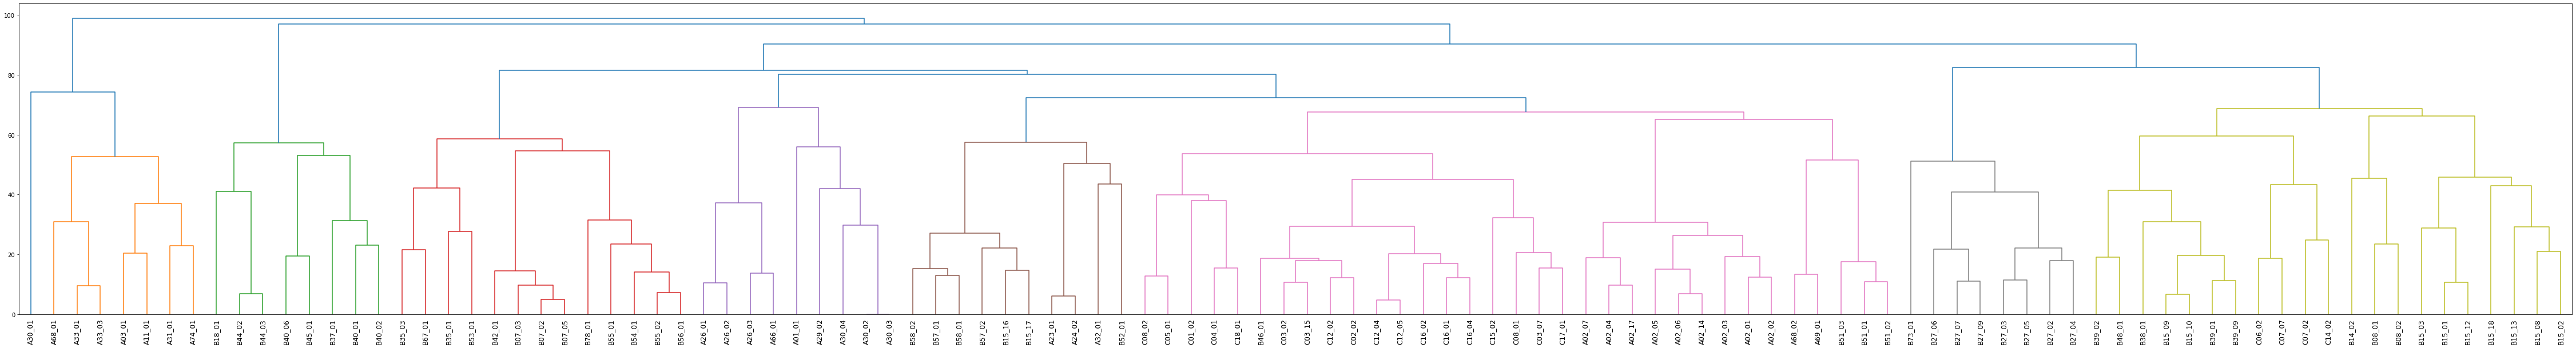

In [11]:
cluster, order = hierarchical_cluster(BA_Mat, N=12, plot_dendro=True)

In [12]:
print(cluster.to_string())

A01_01     3
A26_01     9
A26_02     9
A26_03     9
A30_02     3
A30_03     3
A30_04     3
A32_01     4
A30_01     7
A29_02     3
A02_01     2
A02_02     2
A02_03     2
A02_04     2
A02_05     2
A02_06     2
A02_07     2
A02_14     2
A02_17     2
A68_02     2
A69_01     2
A03_01     8
A11_01     8
A31_01     8
A33_01     8
A33_03     8
A66_01     9
A68_01     8
A74_01     8
A23_01     4
A24_02     4
B07_02     6
B07_03     6
B07_05     6
B15_08     0
B35_01     6
B35_03     6
B42_01     6
B51_01     2
B51_02     2
B51_03     2
B53_01     6
B54_01     6
B55_01     6
B55_02     6
B56_01     6
B67_01     6
B78_01     6
B08_01     0
B08_02     0
B14_02     0
B15_03     0
B15_09     1
B15_10     1
B15_18     0
B27_02    10
B27_03    10
B27_04    10
B27_05    10
B27_06    10
B27_07    10
B27_09    10
B38_01     1
B39_01     1
B39_02     1
B39_09     1
B48_01     1
B73_01    10
B18_01     5
B37_01     5
B40_01     5
B40_02     5
B40_06     5
B44_02     5
B44_03     5
B45_01     5
B15_16     4

### All HLA I alleles

In [42]:
# Mat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure4_total_clustering/Fig4.list", contact=contact, weight=weight, sigma=0.1, w=4)
Mat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure4_total_clustering/Fig4.list", contact=contact, weight=weight)
# print(Mat)
# heatmap(Mat, order=None, line=False, size=(80,80), shrink=0.8, aspect=40, pad=0.02)
# Matrix2Dendro(Mat, "HLA-I_cg.newick")
Mat.to_csv("HLA-I_cg_dist_old.csv")

N=3  SE: 3075.0581802521688 / BE: NA
N=4  SE: 3047.9973617365467 / BE: NA
N=5  SE: 2826.782172694171 / BE: NA
N=6  SE: 2722.614635365837 / BE: NA
N=7  SE: 2669.2276048083004 / BE: NA
N=8  SE: 2622.76066540132 / BE: NA
N=9  SE: 2552.7185122398723 / BE: NA
N=10  SE: 2511.714325018094 / BE: NA
N=11  SE: 2475.935044607814 / BE: NA
N=12  SE: 2422.350174140733 / BE: NA
N=13  SE: 2382.078728331769 / BE: NA
N=14  SE: 2367.470417212851 / BE: NA
N=15  SE: 2352.22867995589 / BE: NA
N=16  SE: 2313.4486474517334 / BE: NA
N=17  SE: 2296.4781054062432 / BE: NA
N=18  SE: 2263.7339538356514 / BE: NA
N=19  SE: 2231.5688304873684 / BE: NA
N=20  SE: 2166.201430192127 / BE: NA
N=21  SE: 2153.5748588803567 / BE: NA
N=22  SE: 2125.5733557489734 / BE: NA
N=23  SE: 2073.5552349040936 / BE: NA
N=24  SE: 2061.525652001028 / BE: NA
N=25  SE: 2046.6509264446647 / BE: NA
N=26  SE: 2036.3190511200305 / BE: NA
N=27  SE: 1999.863747872252 / BE: NA
N=28  SE: 1987.4025603755367 / BE: NA
N=29  SE: 1977.2425776645794 / BE

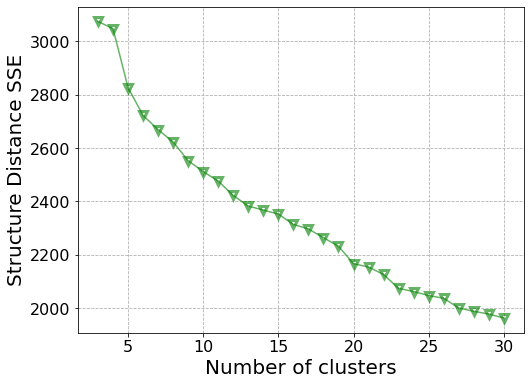

In [47]:
# Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
Mat = pd.read_csv("HLA-I_cg_dist_old.csv", index_col=0)

SSE_struct, _ = Tuning_N(Mat, None, 3, 30)
xx = range(3, 31)

plt.figure(figsize=(8,6))
plt.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="SSE")
# plt.legend()
plt.tick_params('x', labelsize=16)
plt.tick_params('y', labelsize=16)
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Structure Distance SSE', fontsize=20)

plt.grid(linestyle='--')

plt.show()

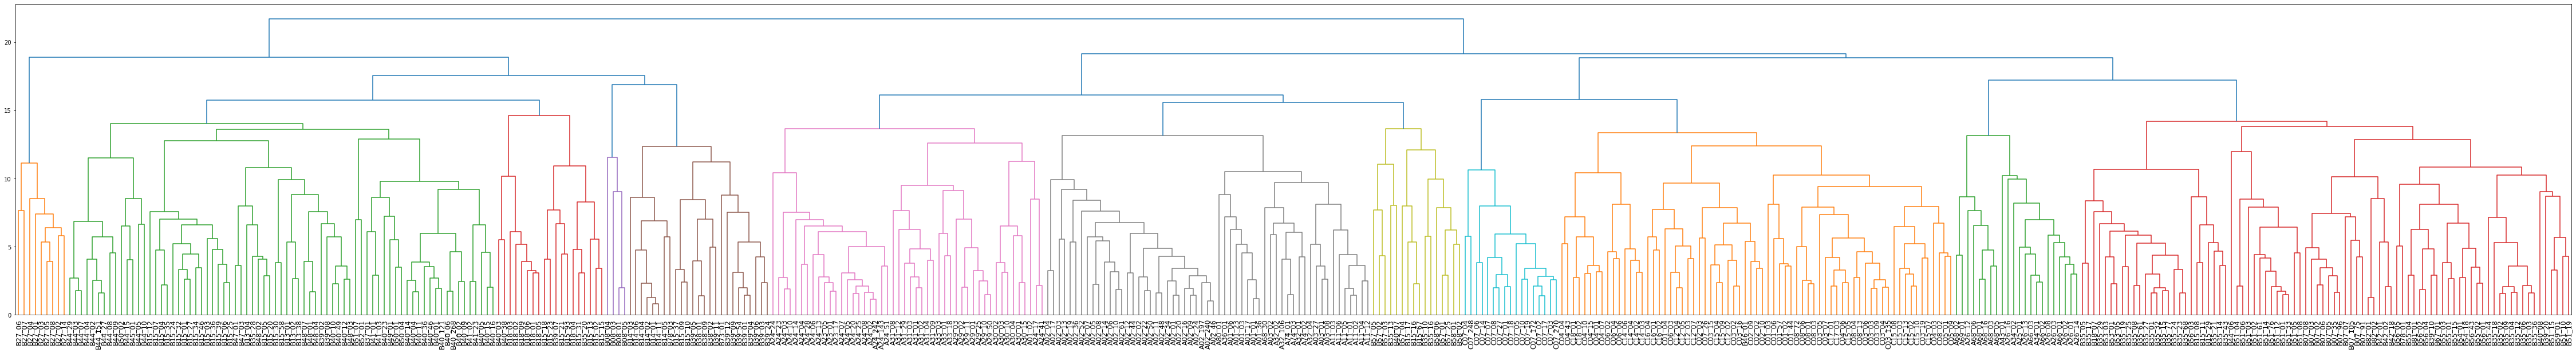

[['B27_06', 'B27_07', 'B27_04', 'B27_01', 'B27_03', 'B27_05', 'B27_08', 'B27_02', 'B27_14'], ['B44_29', 'B44_03', 'B44_07', 'B44_04', 'B44_02', 'B44_151', 'B44_27', 'B44_08', 'B44_09', 'B50_02', 'B44_15', 'B45_01', 'B44_05', 'B44_10', 'B15_12', 'B15_07', 'B15_04', 'B15_35', 'B15_24', 'B15_32', 'B15_01', 'B15_27', 'B15_34', 'B15_46', 'B15_03', 'B15_36', 'B15_39', 'B15_06', 'B15_25', 'B47_01', 'B47_03', 'B13_04', 'B35_28', 'B48_02', 'B15_05', 'B15_20', 'B15_30', 'B15_58', 'B13_01', 'B13_02', 'B13_38', 'B48_07', 'B48_01', 'B48_04', 'B39_02', 'B39_08', 'B40_10', 'B40_49', 'B40_12', 'B48_03', 'B51_07', 'B52_01', 'B37_01', 'B41_01', 'B41_03', 'B40_23', 'B49_01', 'B50_01', 'B50_04', 'B40_14', 'B40_04', 'B40_11', 'B40_36', 'B40_46', 'B40_01', 'B40_121', 'B40_06', 'B40_268', 'B40_02', 'B40_09', 'B41_02', 'B41_23', 'B40_05', 'B40_15', 'B40_16'], ['B40_03', 'B40_38', 'B18_03', 'B18_02', 'B18_09', 'B18_06', 'B18_01', 'B18_05', 'B15_18', 'B15_23', 'B39_07', 'B15_21', 'B15_93', 'B18_04', 'B15_31', '

In [17]:
Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
cluster, order = hierarchical_cluster(Mat, N=12, L='complete', color_threshold=None, plot_dendro=True, outtree="Fig4-24.newick")

name_order = Mat.index[order].to_list()
group_dict = cluster.to_dict()

full_CG_order = []
temp_group = None
last_group = -1
for name in name_order:
    if group_dict[name] != last_group:
        temp_group = []
        full_CG_order.append(temp_group)

    temp_group.append(name)
    last_group = group_dict[name]

print(full_CG_order)

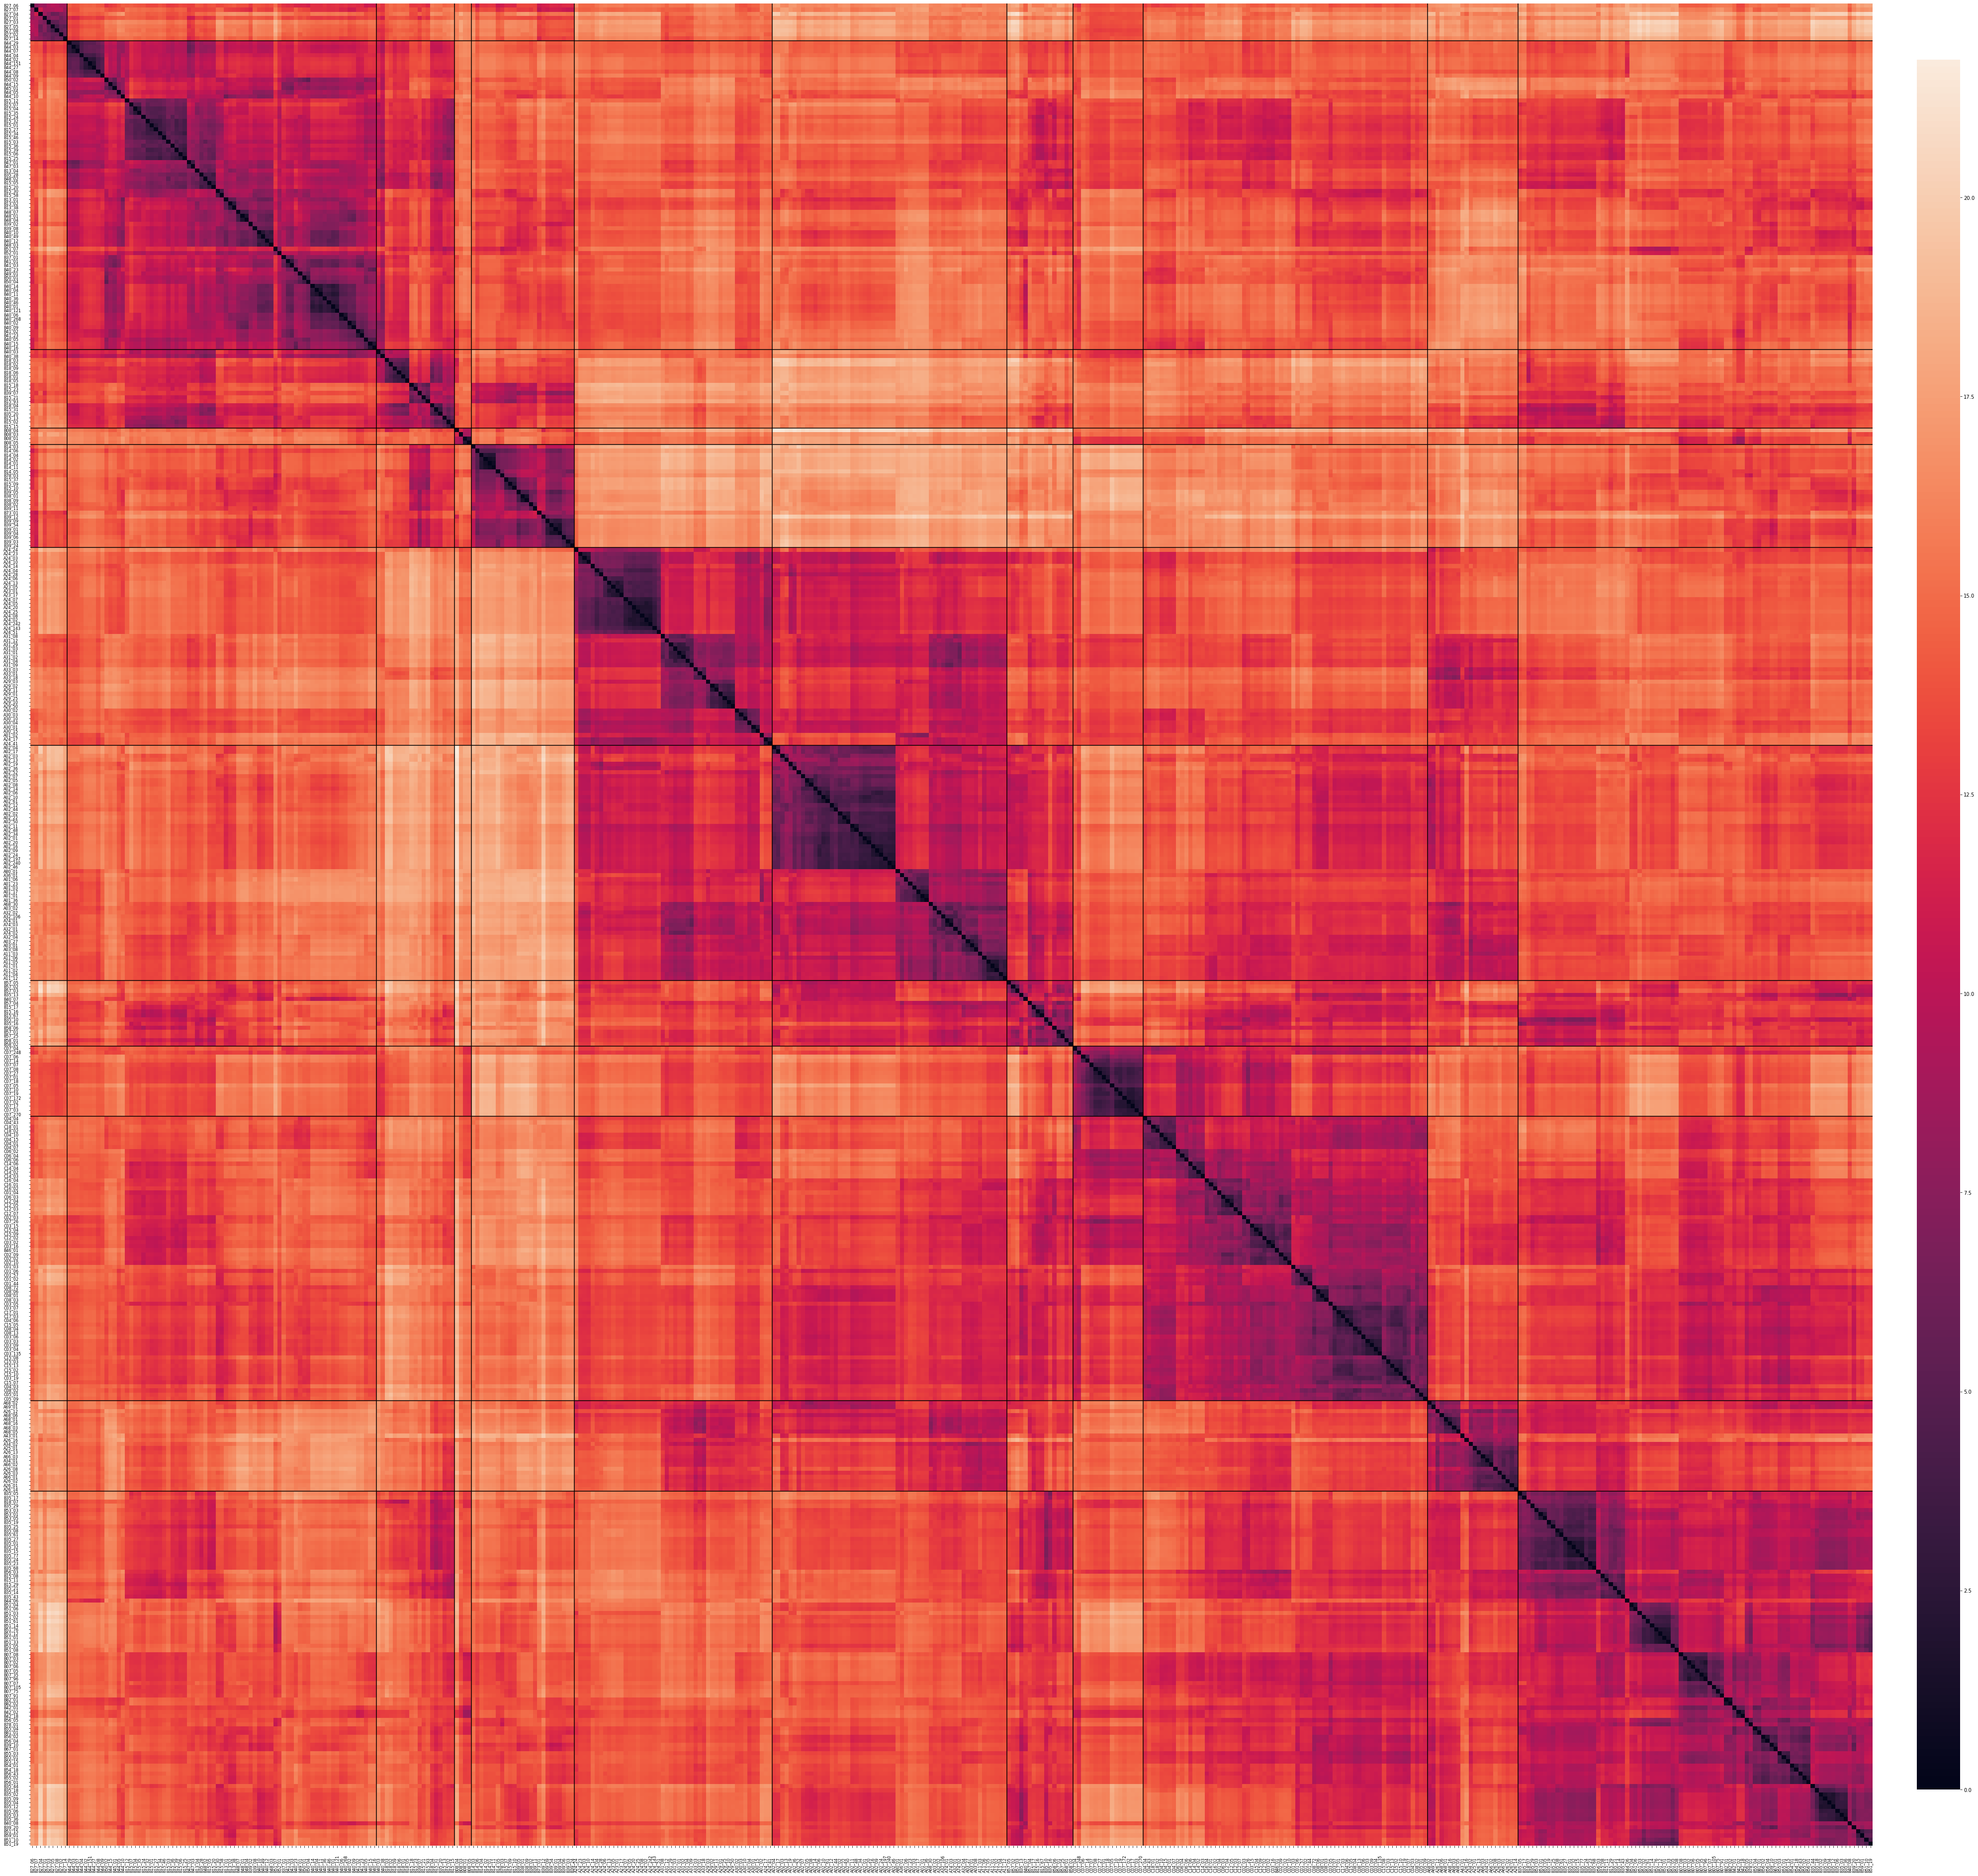

In [23]:
heatmap(Mat, order=full_CG_order, size=(80,80), line=True, shrink=0.8, aspect=40, pad=0.02)

In [24]:
print(cluster.to_string())

A01_01      5
A01_02      3
A01_03      5
A01_06      5
A01_17      5
A01_23      5
A01_36      5
A02_01      5
A02_02      5
A02_03      5
A02_04      5
A02_05      5
A02_06      5
A02_07      5
A02_08      5
A02_09      5
A02_10      5
A02_11      5
A02_12      5
A02_13      5
A02_14      5
A02_16      5
A02_17      5
A02_19      5
A02_197     5
A02_20      5
A02_22      5
A02_24      5
A02_240     5
A02_34      5
A02_36      5
A02_44      5
A02_46      5
A02_48      5
A02_50      5
A02_52      5
A02_61      5
A03_01      5
A03_02      5
A03_08      5
A03_27      5
A11_01      5
A11_02      5
A11_03      5
A11_04      5
A11_05      5
A11_06      5
A11_12      5
A23_01      3
A23_05      3
A23_17      3
A24_02      3
A24_03      3
A24_04      3
A24_05      3
A24_06      3
A24_07      3
A24_08      3
A24_10      3
A24_13      3
A24_14      3
A24_143     3
A24_17      3
A24_20      3
A24_23      3
A24_24      3
A24_242     3
A24_25      3
A24_28      3
A24_41      3
A24_51      3
A25_01